## Initial Setup

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 29 kB/s 
     |████████████████████████████████| 199 kB 45.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=202c2ebadc81b9790cb042a00f2ea68eff5dd93f5ae6c6a58cb2561b5db882c3
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Basics").getOrCreate()

In [4]:
spark

In [ ]:
# Run this everytime you create a new spark instance. 

spark.sparkContext.install_pypi_package("plotly==5.5.0")
spark.sparkContext.install_pypi_package("pandas==0.25.1")
spark.sparkContext.install_pypi_package("numpy==1.14.5")
spark.sparkContext.install_pypi_package("matplotlib==3.1.1")

In [16]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Write all import commands here 
import pandas as pd
import plotly
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.types import StructType, IntegerType, StringType, FloatType,ArrayType
from pyspark.sql.functions import split, col, regexp_replace , round as round2 , coalesce, lit
import pyspark.sql.functions as F
from pyspark.ml.feature import Bucketizer

## Defining Custom Functions 

In [9]:
def get_quantiles(df, col_name, quantiles_list = [0.01, 0.25, 0.5, 0.75, 0.99]):
    """
    Takes a numerical column and returns column values at requested quantiles

    Inputs 
    Argument 1: Dataframe
    Argument 2: Name of the column
    Argument 3: A list of quantiles you want to find. Default value [0.01, 0.25, 0.5, 0.75, 0.99]

    Output 
    Returns a dictionary with quantiles as keys and column quantile values as values 
    """
    # Get min, max and quantile values for given column

    quantiles_list.append(0)
    quantiles_list.append(1)
    quantiles_list = list(set(quantiles_list))
    quantiles_dict = {}
    # Store min, quantiles and max in output dict, sequentially
    for qnt in quantiles_list:
      quantiles_dict[qnt] = df.select(F.percentile_approx(col_name,qnt,10)).collect()[0][0]


    # Store min, quantiles and max in output dict, sequentially

    return(quantiles_dict)

In [10]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code.  

Test_data = [[25, 23, 21, 30, 11, 6, 1, 3, 5, 28, 4, 24, 24, 14, 25, 29, 15, 2, 27, 9, 11, 22, 11, 11, 11, 14, 1, 25, 8, 18, 20, 26, 13, 1, 4, 23, 20, 17, 9, 27, 4, 23, 26, 14, 13, 1, 27, 18, 19, 19],
             [21, 21, 16, 17, 8, 26, 16, 11, 9, 30, 25, 24, 5, 12, 26, 17, 11, 15, 5, 12, 3, 1, 10, 9, 15, 2, 5, 17, 4, 3, 12, 20, 21, 23, 23, 21, 26, 21, 14, 13, 16, 29, 26, 6, 14, 25, 14, 5, 18, 2],
             [18, 24, 26, 10, 28, 12, 1, 11, 30, 10, 1, 24, 5, 1, 3, 29, 2, 27, 5, 15, 23, 26, 14, 13, 6, 9, 28, 2, 27, 9, 26, 1, 28, 10, 27, 23, 12, 25, 28, 25, 8, 15, 11, 10, 11, 5, 14, 4, 3, 3],
             [15, 4, 15, 8, 1, 1, 28, 13, 26, 5, 27, 15, 11, 13, 29, 1, 5, 15, 12, 29, 9, 17, 20, 19, 7, 15, 26, 28, 5, 7, 8, 21, 14, 20, 15, 4, 5, 18, 6, 29, 12, 20, 18, 7, 18, 25, 27, 19, 6, 21]]

columns = ["Test_col_1", "Test_col_2", "Test_col_3", "Test_col_4"]

quantiles_test_df = spark.createDataFrame(Test_data, columns)

assert get_quantiles(quantiles_test_df, "Test_col_1", quantiles_list = [0.5]) == {0.0: 15, 0.5: 18.0, 1.0: 25}, "Recheck the get_quantiles function"
assert get_quantiles(quantiles_test_df, "Test_col_2", quantiles_list = [0.6]) == {0.0: 4, 0.6: 23.0, 1.0: 24}, "Recheck the get_quantiles function"
assert get_quantiles(quantiles_test_df, "Test_col_3", quantiles_list = [0.25]) == {0.0: 15, 0.25: 15.0, 1.0: 26}, "Recheck the get_quantiles function"
assert get_quantiles(quantiles_test_df, "Test_col_4") == {0.0: 8, 0.01: 8.0, 0.25: 8.0, 0.5: 10.0, 0.75: 17.0, 0.99: 30.0, 1.0: 30}, "Recheck the get_quantiles function"

In [11]:
def plot_bucketwise_statistics (summary, bucketizer):
    """
    Takes in a dataframe and a bucketizer object and plots the summary statistics for each bucket in the dataframe. 
  
    Inputs
    Argument 1: Pandas dataframe obtained from bucket_col_print_summary function 
    Argument 2: Bucketizer object obtained from bucket_col_print_summary function
  
    Output
    Displays a plot of bucketwise average ratings nunber of ratings of a parameter.   
    """
    # Creating bucket labels from splits
    classlist = bucketizer.getSplits()
    number_of_classes = len(classlist) - 1

    class_labels = []
    hover_labels = []
    for i in range (number_of_classes):
        hover_labels.append(str(classlist[i])+"-"+str(classlist[i+1]) +" (Bucket name: "+ str(int(i)) +")"  )
        class_labels.append(str(classlist[i])+"-"+str(classlist[i+1]) )
  
    summary["Scaled_number"] = (summary["n_ratings"]-summary["n_ratings"].min())/(summary["n_ratings"].max()-summary["n_ratings"].min()) + 1.5
    summary['Bucket_Names'] = class_labels
  
    # making plot
    x = summary["Bucket_Names"]
    y1 = summary["avg_rating"]
    y2 = summary["n_ratings"]
    err = summary["stddev_rating"]  

    # Plot scatter here
    plt.rcParams["figure.figsize"] = [summary.shape[0]+2, 6.0]
    plt.rcParams["figure.autolayout"] = True
    fig, ax1 = plt.subplots()

    bar = ax1.bar(x, y1, color = "#262261")
    ax1.errorbar(x, y1, yerr=err, fmt="o", color="#EE4036")
    ax1.set(ylim=(0, 7))
  
    #ax1.bar_label(bar , fmt='%.2f', label_type='edge')  
    def barlabel(x_list,y_list):
        for i in range(len(x_list)):
            ax1.text(i,y_list[i] + 0.2,y_list[i], ha = 'center',
  			         fontdict=dict(size=10),
  			         bbox=dict(facecolor='#262261', alpha=0.2)         
  			        )
    barlabel(summary["Bucket_Names"].tolist() ,summary["avg_rating"].round(2).tolist())
  
    ax2 = ax1.twinx()
    ax2.scatter(x, y2, s=summary["Scaled_number"]*500, c = '#FAAF40')  
    ax2.set(ylim=(0, summary["n_ratings"].max()*1.15))
    def scatterlabel(x_list,y_list):
  	    for i in range(len(x_list)):
  		    ax2.text(i,y_list[i] + 15000,y_list[i], ha = 'center',
  					 fontdict=dict(size=10),
                     bbox=dict(facecolor='#FAAF40', alpha=0.5)
  					)
    scatterlabel(summary["Bucket_Names"].tolist() ,summary["n_ratings"].tolist())
  
    # giving labels to the axises
    ax1.set_xlabel(bucketizer.getOutputCol(), fontdict=dict(size=14)) 
    ax1.set_ylabel("Average Ratings",fontdict=dict(size=14))
  
    # secondary y-axis label
    ax2.set_ylabel('Number of Ratings',fontdict=dict(size=14))
  
    #plot Title
    plt.title('Bucketwise average ratings and number of ratings for \n'+bucketizer.getInputCol(), 
              fontdict=dict(size=14))  

In [12]:
def bucket_col_print_summary(df, splits, inputCol, outputCol):
    """
    Given a numerical column in a data frame, adds a bucketized version of the column to the data frame, according to splits provided.
    Also prints a summary of ratings seen in each bucket made.

    Inputs 
    Argument 1: Data Frame 
    Argument 2: Values at which the column will be split
    Argument 3: Name of the input column (numerical column)
    Argument 4: Name of the output column (bucketized numerical column)

    Output: 
    1) New dataframe with the output column added
    2) Bucketizer object trained from the input column 
    3) Pandas dataframe with summary statistics for ratings seen in buckets of the output column
    Also plots summary statistics for ratings seen in buckets of the output column
    """

    # Dropping bucket if it already exists
    # if outputCol in df.columns:
    #   df = df.drop(outputCol)

    # Training bucketizer
    # bucketizer is an inbuilt feature transformer in SparkML 
    # use the bucketizer to create buckets and transfrom features
    bucketizer = Bucketizer(splits = splits,
                          inputCol  = inputCol,
                          outputCol = outputCol)
    

    df = bucketizer.setHandleInvalid("keep").transform(df)



    # Printing meta information on buckets created
    print("Added bucketized column {}".format(outputCol))
    print("")
    print("Bucketing done for split definition: {}".format(splits))
    print("")  
    print("Printing summary statistics for ratings in buckets below:")

    # Creating a summary statistics dataframe and passing it to the plotting function
    summary =  (df.groupby(outputCol) \
                  .agg(F.avg('rating').alias('avg_rating'),\
                  F.count('rating').alias('n_ratings'),\
                  F.stddev('rating').alias('stddev_rating') \
                  )\
                # Write code to create a summary data frame. Ensure the summary df is pandas df. 
                # The data frame must have average ratings per bucket, standard deviation per bucket, number of ratings per bucket
                .toPandas().sort_values(by=outputCol))
    
    # uncomment the line below after you ensure this function is wokring correctly.  
    plot_bucketwise_statistics(summary,bucketizer)
  
    return df, bucketizer, summary

In [13]:
def get_column_distribution_summary(df, col_name):
    """
    Takes a column in a data frame and prints the summary statistics (average, standard deviation, count and distinct count) 
    for all unique values in that column.
  
    Inputs 
    Argument 1: Dataframe 
    Argument 2: Name of the column
  
    Output
    Returns nothing 
    Prints a Dataframe with summary statistics
    """
    summary =  (df.groupby(col_name) \
                  .agg(F.avg('rating').alias('avg_rating'),\
                  F.count('rating').alias('n_ratings'),\
                  F.stddev('rating').alias('stddev_rating'), \
                  F.countDistinct('recipe_id').alias('n_recipes')\
                  )\
                # Write code to create a summary data frame. Ensure the summary df is pandas df. 
                # The data frame must have average ratings per bucket, standard deviation per bucket, number of ratings per bucket
                .toPandas())
    
    print(summary.sort_values(by = col_name)
      #df.agg(F.avg(col_name).alias('Average'),F.stddev(col_name).alias('Standard Deviation'),F.count(col_name).alias('Count'),F.countDistinct(col_name).alias('Distinct Count') ).show()
          # add code here 
          )

In [14]:
def get_n_items_satisfying_condition (df, condition, aggregation_level = "recipe"):
    """
    Given a condition, find the number of recipes / reviews that match the condition.
    Also calculates the percentage of such recipes / reviews as a percentage of all recipes / reviews.
  
    Inputs 
    Argument 1: Dataframe 
    Argument 2: Logical expression describing a condition, string type. eg: "minutes == 0"
    Argument 3: Aggregation level for determining "items", either  "recipe" or "review". Default value == "recipe"
  
    Output: Returns no object.
    Prints the following:
    1) Number of recipes / reviews that satisfy the condition
    2) Total number of recipes / reviews in the dataframe
    3) Percentage of recipes / reviews that satisfy the condition
    """
    # Find out num rows satisfying the condition
    if aggregation_level == "recipe": 
        number_of_rows_satisfying_condition = (df
                                             .filter(condition)
                                             .agg(F.countDistinct("id"))).first()[0]
      
        n_rows_total = (df.agg(F.countDistinct("id"))).first()[0]
    if aggregation_level == "review":
        number_of_rows_satisfying_condition = (df
                                             .filter(condition)
                                             .agg(F.countDistinct("id","user_id"))).first()[0]
        n_rows_total = (df.agg(F.countDistinct("id","user_id"))).first()[0]
  
    # Find out % rows satisfying the conditon and print a properly formatted output
    perc_rows = round(number_of_rows_satisfying_condition * 100/ n_rows_total, 2)
    print('Condition String                   : "{}"'.format(condition))
    print("Num {}s Satisfying Condition   : {} [{}%]".format(aggregation_level.title(), number_of_rows_satisfying_condition, perc_rows))
    print("Total Num {}s                  : {}".format(aggregation_level.title(), n_rows_total))

## Read the data

- Read ```interaction_level_df_processed```

In [17]:
interaction_level_df = spark.read.parquet(
                                          'drive/MyDrive/food_recommender_assignment/interaction_level_df_v2.parquet'
                                          )

In [18]:
# Code check cell
# Do not edit cells with assert commands
# If an error is shown after running this cell, please recheck your code.  

assert interaction_level_df.count() == 1132367, "There is a mistake in reading the data."
assert len(interaction_level_df.columns) == 33, "There is a mistake in reading the data."

In [19]:
interaction_level_df.show(5)

+-------+---------+------+--------------------+-------------------+--------------------+---+-------+--------------+----------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------------+--------+-------------+---------+----------+-----------+-----------------+-----------------+---------------------+-----------------+------------------+-------------------+-------------------------+-------------------------+------------------------------------+--------------------------------------+-------------------------------------+
|user_id|recipe_id|rating|              review|        review_date|                name| id|minutes|contributor_id| submitted|                tags|           nutrition|n_steps|               steps|         description|         ingredients|n_ingredients|calories|total_fat_PDV|sugar_PDV|sodium_PDV|protein_PDV|saturated_fat_PDV|carbohydrates_PDV|total_fat_per_100_cal|sugar_per_100_cal|sodium_per_100_cal|prote

## Bucketing and Cleaning Numerical Features

#### **1. `years_since_submission_on_review_date`** 
[Review Time Since Submission]
- Recipes more than 6 years old are rated low

In [20]:
get_quantiles(df = interaction_level_df,
              col_name = "years_since_submission_on_review_date")

{0.25: 1.0967741933333335,
 0.5: 2.9677419358333332,
 0.99: 19.284946236666666,
 0.75: 5.9569892475,
 0: -4.833333333333333,
 1: 19.284946236666666,
 0.01: -4.833333333333333}

In [21]:
get_n_items_satisfying_condition(df = interaction_level_df,
                                 condition= 'years_since_submission_on_review_date < 0',
                                 aggregation_level= "review")

Condition String                   : "years_since_submission_on_review_date < 0"
Num Reviews Satisfying Condition   : 1246 [0.11%]
Total Num Reviews                  : 1132367


In [22]:
# Only keep interactions with review dates >= recipe submission date

interaction_level_df = (interaction_level_df
                        .filter('years_since_submission_on_review_date >= 0'))

Added bucketized column years_since_submission_on_review_date_bucket

Bucketing done for split definition: [0, 1, 3, 6, inf]

Printing summary statistics for ratings in buckets below:


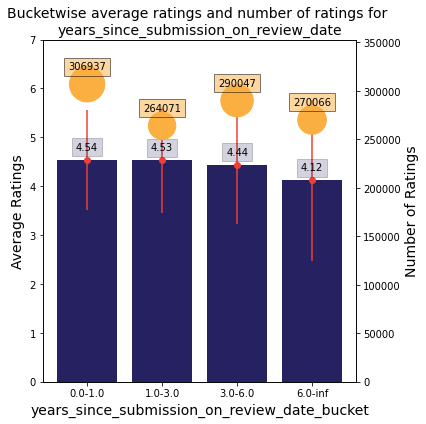

In [23]:
splits = [ 0, 1, 3, 6, float('Inf')]
inputCol  = "years_since_submission_on_review_date"
outputCol = "years_since_submission_on_review_date_bucket"

(interaction_level_df, submission_time_bucketizer, submission_time_pandas_df) = bucket_col_print_summary(df = interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

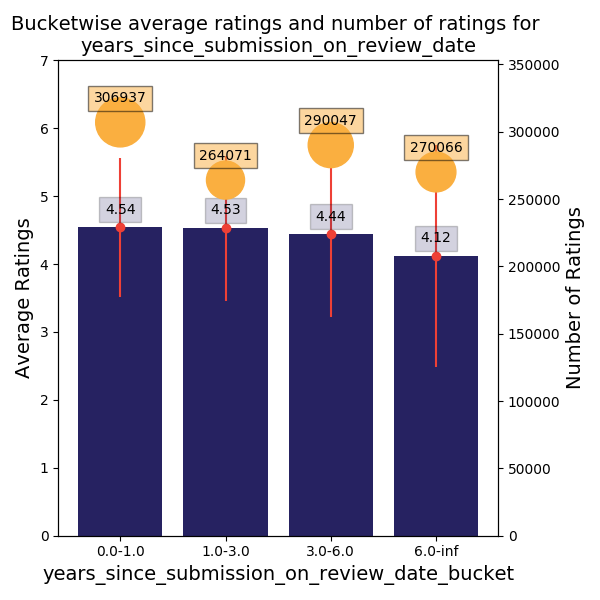

In [ ]:
%matplot plt

#### **2. `minutes`** 

[prep time]
- Somewhat relevant
- Low prep time is preferred

In [24]:
get_quantiles(df = interaction_level_df,
              col_name = "minutes")

{0.25: 25, 0.5: 40, 0.99: 2147483647, 0.75: 70, 0: 0, 1: 2147483647, 0.01: 0}

In [25]:
# Capping prep time at 930 minutes
interaction_level_df = interaction_level_df.withColumn('minutes', F.when(interaction_level_df.minutes >=930,930).otherwise(interaction_level_df.minutes))

In [26]:
# investigating recipes with minutes = 0 -> Look at n_steps for such recipes.
interaction_level_df.createOrReplaceTempView('interaction_level_df')
interaction_level_df = spark.sql("SELECT *, case when n_steps >=10 then '>=10' "
"when n_steps=1 then '01' when n_steps = 2 then '02'"
"when n_steps=3 then '03' when n_steps = 4 then '04'"
"when n_steps=5 then '05' when n_steps = 6 then '06'"
"when n_steps=7 then '07' when n_steps = 8 then '08'"
"when n_steps=9 then '09' end as n_steps_modified from interaction_level_df;")

get_column_distribution_summary(
interaction_level_df.filter('minutes==0'), 'n_steps_modified'
)

  n_steps_modified  avg_rating  n_ratings  stddev_rating  n_recipes
1               01    4.240000         25       1.090871         12
7               02    4.442308        104       1.086787         28
6               03    3.989130        184       1.575041         44
9               04    4.306358        173       1.386737         57
4               05    4.231788        302       1.356386         90
8               06    4.470703        512       1.146389        102
0               07    4.344743        409       1.287564         92
5               08    4.381995        411       1.277409         92
2               09    4.076190        315       1.527009         86
3             >=10    4.240964       2075       1.376816        491


In [27]:
# let's look at some examples with 1 step only to see if this makes sense
interaction_level_df.filter('n_steps ==1')

DataFrame[user_id: int, recipe_id: int, rating: int, review: string, review_date: timestamp, name: string, id: int, minutes: int, contributor_id: int, submitted: date, tags: array<string>, nutrition: string, n_steps: int, steps: string, description: string, ingredients: string, n_ingredients: int, calories: float, total_fat_PDV: float, sugar_PDV: float, sodium_PDV: float, protein_PDV: float, saturated_fat_PDV: float, carbohydrates_PDV: float, total_fat_per_100_cal: float, sugar_per_100_cal: float, sodium_per_100_cal: float, protein_per_100_cal: float, saturated_fat_per_100_cal: float, carbohydrates_per_100_cal: float, days_since_submission_on_review_date: int, months_since_submission_on_review_date: double, years_since_submission_on_review_date: double, years_since_submission_on_review_date_bucket: double, n_steps_modified: string]

In [28]:
get_n_items_satisfying_condition(df = interaction_level_df,
                                 condition= 'minutes == 0')

Condition String                   : "minutes == 0"
Num Recipes Satisfying Condition   : 1094 [0.47%]
Total Num Recipes                  : 231501


In [29]:
# Remove recipes with cook time zero

interaction_level_df = (interaction_level_df
                        .filter('minutes > 0'))



Added bucketized column prep_time_bucket

Bucketing done for split definition: [0, 5, 15, 30, 60, 300, 900, inf]

Printing summary statistics for ratings in buckets below:


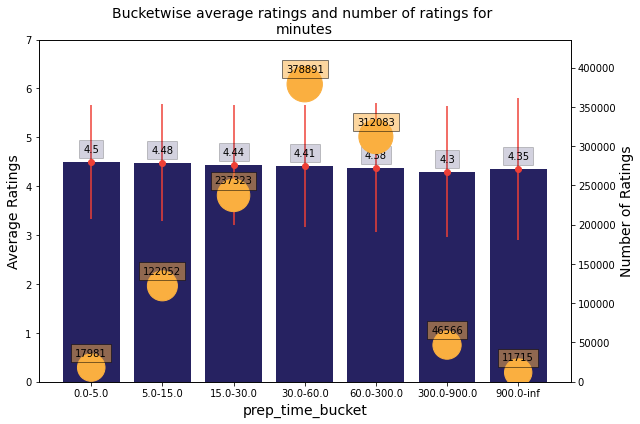

In [30]:
splits = [0, 5, 15, 30, 60, 300, 900, float('Inf')]
inputCol  = "minutes"
outputCol = "prep_time_bucket"

(interaction_level_df, prep_time_bucketizer, prep_time_pandas_df) = bucket_col_print_summary(df = interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

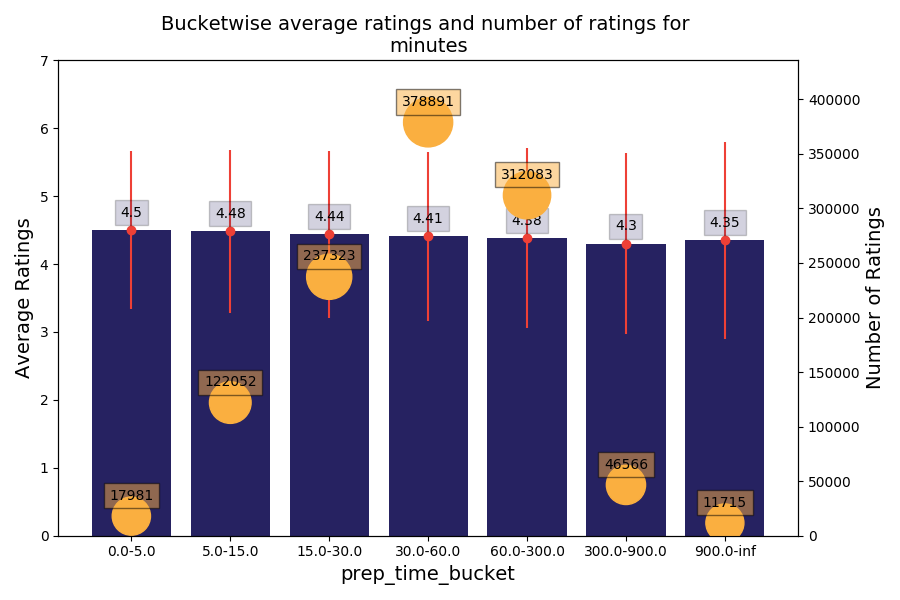

In [ ]:
# this will display the plot 
%matplot plt

**3. `n_steps`**

- Clearly relevant
- Recipes with less than 2 steps are rated high
- Recipes with more than 29 steps are rated very low

In [31]:
get_quantiles(df = interaction_level_df,
              col_name = "n_steps")

{0.25: 6, 0.5: 8, 0.99: 145, 0.75: 12, 0: 0, 1: 145, 0.01: 0}

In [32]:
interaction_level_df.show(2)

+-------+---------+------+--------------------+-------------------+--------------------+---+-------+--------------+----------+--------------------+--------------------+-------+--------------------+--------------------+--------------------+-------------+--------+-------------+---------+----------+-----------+-----------------+-----------------+---------------------+-----------------+------------------+-------------------+-------------------------+-------------------------+------------------------------------+--------------------------------------+-------------------------------------+--------------------------------------------+----------------+----------------+
|user_id|recipe_id|rating|              review|        review_date|                name| id|minutes|contributor_id| submitted|                tags|           nutrition|n_steps|               steps|         description|         ingredients|n_ingredients|calories|total_fat_PDV|sugar_PDV|sodium_PDV|protein_PDV|saturated_fat_PDV|car

In [33]:
get_n_items_satisfying_condition(df = interaction_level_df,
                                 condition= 'n_steps == 0')

Condition String                   : "n_steps == 0"
Num Recipes Satisfying Condition   : 1 [0.0%]
Total Num Recipes                  : 230407


In [34]:
# Remove recipes with n_steps zero
interaction_level_df = interaction_level_df.filter('n_steps > 0 ')

Added bucketized column n_steps_bucket

Bucketing done for split definition: [0, 2, 6, 8, 12, 29, inf]

Printing summary statistics for ratings in buckets below:


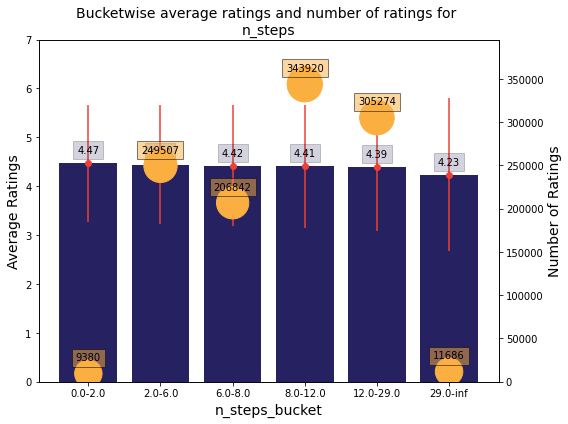

In [35]:
splits =  [0, 2, 6, 8, 12, 29, float('Inf')]
inputCol  = "n_steps"
outputCol = "n_steps_bucket"

(interaction_level_df, n_steps_bucketizer, n_steps_pandas_df) = bucket_col_print_summary(df = interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

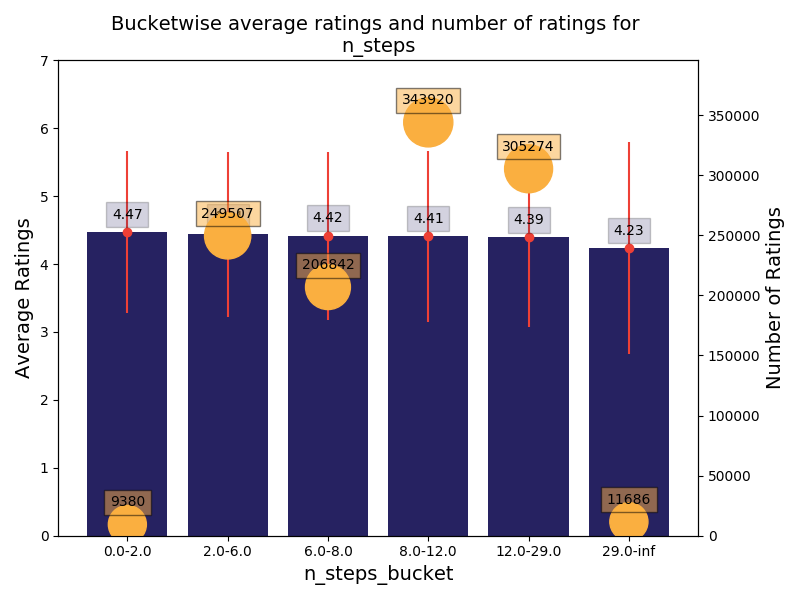

In [ ]:
# this will display the plot 
%matplot plt

**4. `n_ingredients`**
- Not relevant

In [36]:
get_quantiles(df = interaction_level_df,
              col_name = "n_ingredients")

{0.25: 7, 0.5: 8, 0.99: 43, 0.75: 11, 0: 1, 1: 43, 0.01: 1}

Added bucketized column n_ingredients_bucket

Bucketing done for split definition: [0, 6, 9, 11, inf]

Printing summary statistics for ratings in buckets below:


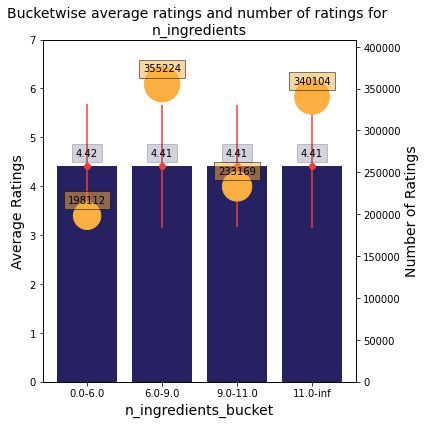

In [37]:
splits =  [0, 6, 9, 11, float('Inf')]
inputCol  = "n_ingredients"
outputCol = "n_ingredients_bucket"

(interaction_level_df, n_ingredients_bucketizer, n_ingredients_pandas_df) = bucket_col_print_summary(df = interaction_level_df,
                                                                              splits = splits,
                                                                              inputCol  = inputCol,
                                                                              outputCol = outputCol)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

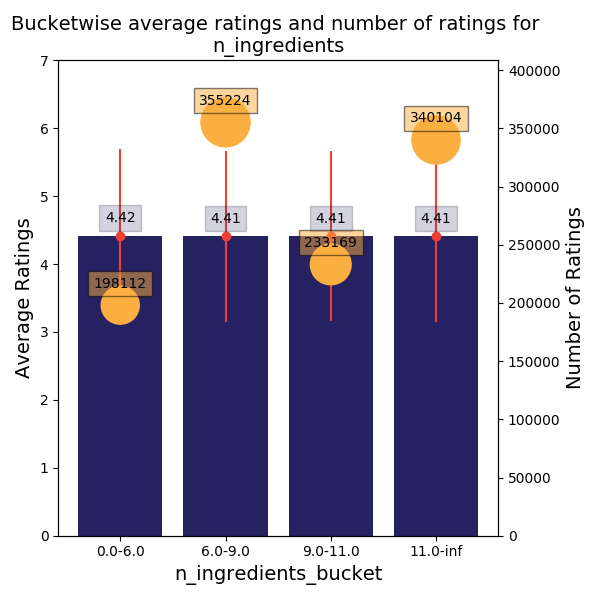

In [ ]:
# this will display the plot 
%matplot plt

**5. `nutrition` columns**

- `calories` - Calories per serving seems irrelevant
- `fat (per 100 cal)` - Calories per serving seems irrelevant
- `sugar (per 100 cal)` - Calories per serving seems irrelevant
- `sodium (per 100 cal)` - Calories per serving seems irrelevant
- `protein (per 100 cal)` - Calories per serving seems irrelevant
- `sat. fat (per 100 cal)` - Calories per serving seems irrelevant
- `carbs (per 100 cal)` - Calories per serving seems irrelevant

In [38]:
interaction_level_df.columns 


['user_id',
 'recipe_id',
 'rating',
 'review',
 'review_date',
 'name',
 'id',
 'minutes',
 'contributor_id',
 'submitted',
 'tags',
 'nutrition',
 'n_steps',
 'steps',
 'description',
 'ingredients',
 'n_ingredients',
 'calories',
 'total_fat_PDV',
 'sugar_PDV',
 'sodium_PDV',
 'protein_PDV',
 'saturated_fat_PDV',
 'carbohydrates_PDV',
 'total_fat_per_100_cal',
 'sugar_per_100_cal',
 'sodium_per_100_cal',
 'protein_per_100_cal',
 'saturated_fat_per_100_cal',
 'carbohydrates_per_100_cal',
 'days_since_submission_on_review_date',
 'months_since_submission_on_review_date',
 'years_since_submission_on_review_date',
 'years_since_submission_on_review_date_bucket',
 'n_steps_modified',
 'prep_time_bucket',
 'n_steps_bucket',
 'n_ingredients_bucket']

In [39]:
nutrition_cols = ['calories', 
                  'total_fat_PDV', 
                  'sugar_PDV', 
                  'sodium_PDV', 
                  'protein_PDV', 
                  'saturated_fat_PDV', 
                  'carbohydrates_PDV', 
                  'total_fat_per_100_cal', 
                  'sugar_per_100_cal', 
                  'sodium_per_100_cal', 
                  'protein_per_100_cal', 
                  'saturated_fat_per_100_cal', 
                  'carbohydrates_per_100_cal']



In [40]:
# Write code to find the quantile distribution of all the above columns
dict_data = {}

for col in nutrition_cols:
    print(col)
    dict_data[col] = (get_quantiles(df = interaction_level_df,col_name = col, quantiles_list = [0,0.25,0.5,0.75,0.95,1]))
    print(dict_data[col])
    print('*'*20)

calories
{0: 0.0, 0.25: 189.8000030517578, 0.95: 434360.1875, 0.5: 309.1000061035156, 0.75: 441.29998779296875, 1: 434360.1875}
********************
total_fat_PDV
{0: 0.0, 0.25: 10.0, 0.95: 17183.0, 0.5: 19.0, 0.75: 45.0, 1: 17183.0}
********************
sugar_PDV
{0: 0.0, 0.25: 10.0, 0.95: 362729.0, 0.5: 18.0, 0.75: 58.0, 1: 362729.0}
********************
sodium_PDV
{0: 0.0, 0.25: 7.0, 0.95: 29338.0, 0.5: 16.0, 0.75: 29.0, 1: 29338.0}
********************
protein_PDV
{0: 0.0, 0.25: 7.0, 0.95: 6552.0, 0.5: 18.0, 0.75: 50.0, 1: 6552.0}
********************
saturated_fat_PDV
{0: 0.0, 0.25: 9.0, 0.95: 10395.0, 0.5: 21.0, 0.75: 49.0, 1: 10395.0}
********************
carbohydrates_PDV
{0: 0.0, 0.25: 4.0, 0.95: 36098.0, 0.5: 9.0, 0.75: 15.0, 1: 36098.0}
********************
total_fat_per_100_cal
{0: 0.0, 0.25: 4.800000190734863, 0.95: 18.709999084472656, 0.5: 6.5, 0.75: 9.130000114440918, 1: 18.709999084472656}
********************
sugar_per_100_cal
{0: 0.0, 0.25: 3.0899999141693115, 0.95: 1

In [41]:
nutrition_col_quantile_summary = pd.DataFrame() 

for col in nutrition_cols:
    print(col)
    # programatically diclare the arguments of Bucketizer
    splits = [0,dict_data[col][0.25],dict_data[col][0.5],dict_data[col][0.75],dict_data[col][0.95],float('Inf')]
    inputCol  = col
    outputCol = col+'_bucket'
    
    # drop column if it already exists 
    if col+'_bucket' in interaction_level_df.columns:
      interaction_level_df = interaction_level_df.drop(col+'_bucket')


    # Training bucketizer
    bucketizer = Bucketizer(splits = splits,
                          inputCol  = inputCol,
                          outputCol = outputCol)
   
    # apply the bucketizer
  
    interaction_level_df = bucketizer.setHandleInvalid("keep").transform(interaction_level_df)
    
    # create the summary df  
    summary =  (interaction_level_df.groupby(outputCol) \
                  .agg(F.avg('rating').alias(col)
                  )\
                .toPandas().sort_values(by=outputCol)) 
    # the output in the cells below is in the form of pandas but you can keep your result in pyspark as well. 
    print(summary)
    nutrition_col_quantile_summary[col]= summary[col]
    print('*'*5)

calories
   calories_bucket  calories
0              0.0  4.417278
1              1.0  4.428126
3              2.0  4.427313
2              3.0  4.386642
4              4.0  0.000000
*****
total_fat_PDV
   total_fat_PDV_bucket  total_fat_PDV
0                   0.0       4.394814
1                   1.0       4.421913
4                   2.0       4.427641
3                   3.0       4.399407
2                   4.0       4.000000
*****
sugar_PDV
   sugar_PDV_bucket  sugar_PDV
0               0.0   4.418164
1               1.0   4.436029
3               2.0   4.410852
2               3.0   4.392563
4               4.0   0.000000
*****
sodium_PDV
   sodium_PDV_bucket  sodium_PDV
0                0.0    4.421575
1                1.0    4.409169
3                2.0    4.421961
2                3.0    4.398818
4                4.0    3.000000
*****
protein_PDV
   protein_PDV_bucket  protein_PDV
0                 0.0     4.422679
1                 1.0     4.419234
3                 2.0  

In [42]:
# set the max columns to none
pd.set_option('display.max_columns', None)

In [43]:
nutrition_col_quantile_summary.set_index(pd.Index(['0.00-0.25','0.25-0.50','0.50-0.75','0.75-0.95','0.95-1.00']))

,calories,total_fat_PDV,sugar_PDV,sodium_PDV,protein_PDV,saturated_fat_PDV,carbohydrates_PDV,total_fat_per_100_cal,sugar_per_100_cal,sodium_per_100_cal,protein_per_100_cal,saturated_fat_per_100_cal,carbohydrates_per_100_cal
0.00-0.25,4.417278,4.394814,4.418164,4.421575,4.422679,4.400990,4.439453,4.386960,4.412709,4.420880,4.412972,4.398296,4.436549
0.25-0.50,4.428126,4.421913,4.436029,4.409169,4.419234,4.420057,4.421594,4.396848,4.424931,4.398020,4.412636,4.404569,4.428442
0.50-0.75,4.427313,4.399407,4.410852,4.421961,4.409294,4.404530,4.418500,4.413237,4.419515,4.422015,4.419313,4.414358,4.385875
0.75-0.95,4.386642,4.000000,4.392563,4.398818,4.396734,4.000000,4.374647,4.444845,4.396200,4.410815,4.404454,4.427575,3.166667
0.95-1.00,0.000000,4.427641,0.000000,3.000000,4.312500,4.423492,0.000000,3.750000,4.714286,1.000000,3.625000,4.000000,4.403142


In [ ]:
## Writing the modified data to S3 

interaction_level_df.write.mode('overwrite').parquet('drive/MyDrive/food_recommender_assignment/interaction_level_df_post_eda.parquet')